# BBM 418 - Computer Vision Laboratory
## Programming Assignment-1: Generalized Hough Transform with Scale and Rotation

**Student Name:** Ahmet Oğuzhan Kökülü  
**Student Number:** 2220356053  
**Description:** Implementation of Generalized Hough Transform (GHT) for object detection with scale and rotation variations

**Date:** October 27, 2025

In [1]:
# Configuration and Directory Setup
import os

# Dataset and Output Directories
DATASET_DIR = "/home/oguzhan/Projects/BBM416_Projects/First_Assignment"
OUTPUT_DIR = os.path.join(DATASET_DIR, "output")

# Create output directory if it doesn't exist
os.makedirs(OUTPUT_DIR, exist_ok=True)

print(f"Dataset Directory: {DATASET_DIR}")
print(f"Output Directory: {OUTPUT_DIR}")

Dataset Directory: /home/oguzhan/Projects/BBM416_Projects/First_Assignment
Output Directory: /home/oguzhan/Projects/BBM416_Projects/First_Assignment/output


## 1. Introduction

The **Generalized Hough Transform (GHT)** is an extension of the classical Hough Transform that enables detection of arbitrary shapes in images, even when they undergo transformations such as scaling and rotation. Unlike the standard Hough Transform which is limited to detecting parameterized shapes (e.g., lines, circles), GHT can detect any shape by using an **R-table** representation.

### How GHT Works:
1. **R-Table Construction**: During the training phase, we build an R-table from the template image. The R-table maps gradient directions to displacement vectors (from edge points to a reference point, typically the center).
2. **Voting Process**: During detection, edge points in the scene image vote for potential reference point locations using the R-table, considering different scales and rotations.
3. **Peak Detection**: Locations with the highest votes in the accumulator represent detected object instances.

### Assignment Goal:
In this assignment, we implement GHT to detect template objects in scene images with:
- **Scale variations**: 1.0×, 1.5×, 2.0×, and 3.0×
- **Rotation variations**: multiples of 15° (0°, 15°, 30°, ..., 345°)
- Two datasets: **daisy** and **fish**

In [ ]:
# Import necessary libraries
import numpy as np
import cv2
import matplotlib.pyplot as plt
from scipy import ndimage
from collections import defaultdict
import warnings
warnings.filterwarnings('ignore')

# Set matplotlib parameters for better visualization
plt.rcParams['figure.figsize'] = (15, 10)
plt.rcParams['figure.dpi'] = 100

Libraries imported successfully!


## 2. Edge Detection

Edge detection is crucial for GHT as it identifies the shape boundaries. We'll use the **Canny edge detector** because:
- It provides thin, well-localized edges
- It includes non-maximum suppression to reduce noise
- It uses double thresholding for robust edge detection
- It computes gradient directions which are essential for GHT

In [ ]:
def detect_edges(image, low_threshold=50, high_threshold=150):
    """
    Detect edges using Canny edge detector and compute gradients.
    
    Parameters:
    -----------
    image : numpy array
        Input grayscale image
    low_threshold : int
        Lower threshold for Canny edge detection
    high_threshold : int
        Upper threshold for Canny edge detection
        
    Returns:
    --------
    edges : numpy array
        Binary edge map
    gradient_mag : numpy array
        Gradient magnitude
    gradient_angle : numpy array
        Gradient direction in radians
    """
    # Apply Gaussian blur to reduce noise
    blurred = cv2.GaussianBlur(image, (5, 5), 1.4)
    
    # Compute gradients using Sobel operator
    grad_x = cv2.Sobel(blurred, cv2.CV_64F, 1, 0, ksize=3)
    grad_y = cv2.Sobel(blurred, cv2.CV_64F, 0, 1, ksize=3)
    
    # Compute gradient magnitude and angle
    gradient_mag = np.sqrt(grad_x**2 + grad_y**2)
    gradient_angle = np.arctan2(grad_y, grad_x)  # Returns angle in radians [-pi, pi]
    
    # Apply Canny edge detection
    edges = cv2.Canny(blurred, low_threshold, high_threshold)
    
    return edges, gradient_mag, gradient_angle

Edge detection function defined!


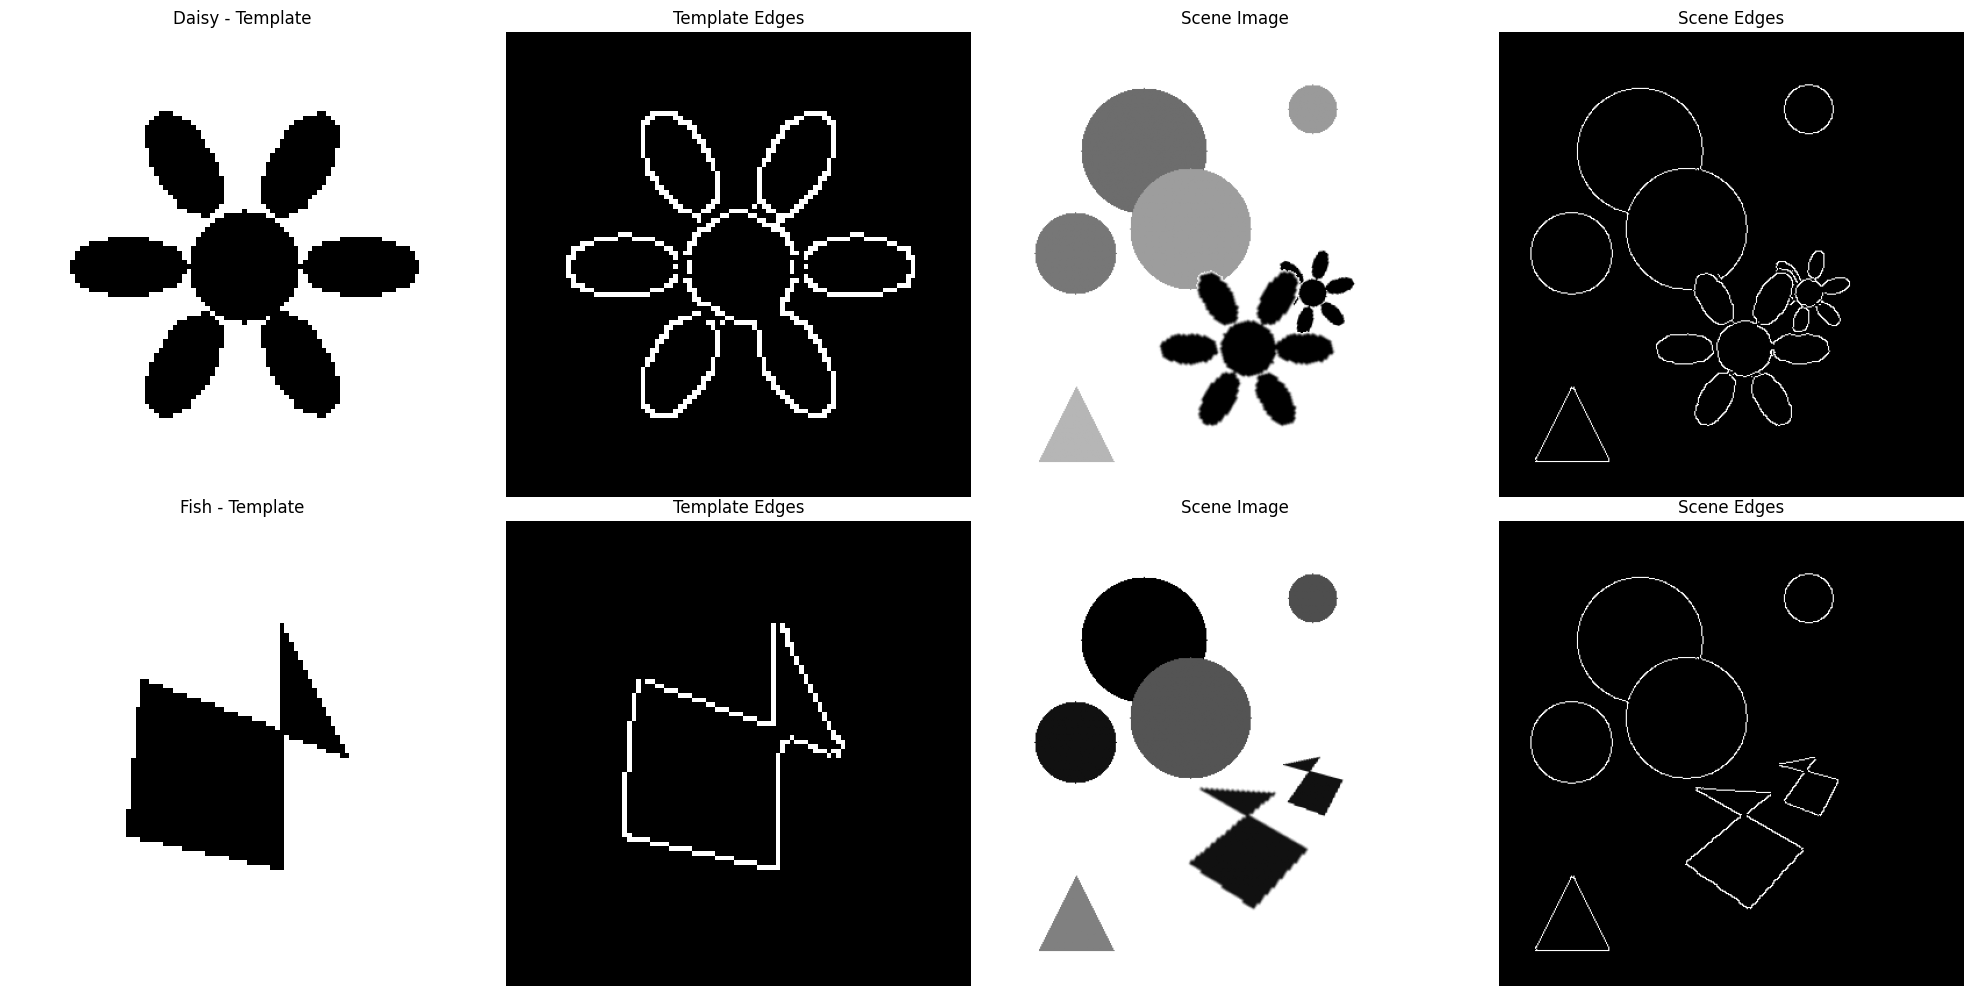

Edge detection visualization complete!


In [ ]:
# Test edge detection on template images
datasets = ['dataset_daisy', 'dataset_fish']

fig, axes = plt.subplots(2, 4, figsize=(20, 10))

for idx, dataset in enumerate(datasets):
    # Load template
    template_path = os.path.join(DATASET_DIR, dataset, 'template.png')
    template = cv2.imread(template_path, cv2.IMREAD_GRAYSCALE)
    
    # Load a scene image
    scene_path = os.path.join(DATASET_DIR, dataset, 'scene_00.png')
    scene = cv2.imread(scene_path, cv2.IMREAD_GRAYSCALE)
    
    # Detect edges
    template_edges, _, _ = detect_edges(template)
    scene_edges, _, _ = detect_edges(scene)
    
    # Display results
    axes[idx, 0].imshow(template, cmap='gray')
    axes[idx, 0].set_title(f'{dataset.split("_")[1].capitalize()} - Template')
    axes[idx, 0].axis('off')
    
    axes[idx, 1].imshow(template_edges, cmap='gray')
    axes[idx, 1].set_title('Template Edges')
    axes[idx, 1].axis('off')
    
    axes[idx, 2].imshow(scene, cmap='gray')
    axes[idx, 2].set_title('Scene Image')
    axes[idx, 2].axis('off')
    
    axes[idx, 3].imshow(scene_edges, cmap='gray')
    axes[idx, 3].set_title('Scene Edges')
    axes[idx, 3].axis('off')

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'edge_detection_results.png'), dpi=150, bbox_inches='tight')
plt.show()

## 3. Generalized Hough Transform Implementation

### 3.1 R-Table Construction

The R-table is the core data structure of GHT. For each quantized gradient direction, it stores displacement vectors from edge points to the reference point (center of the template).

In [ ]:
class GeneralizedHoughTransform:
    """
    Generalized Hough Transform for object detection with scale and rotation invariance.
    """
    
    def __init__(self, template_image, num_angle_bins=36):
        """
        Initialize GHT with a template image.
        
        Parameters:
        -----------
        template_image : numpy array
            Grayscale template image
        num_angle_bins : int
            Number of bins for quantizing gradient angles (default: 36 for 10° bins)
        """
        self.template = template_image
        self.num_angle_bins = num_angle_bins
        self.angle_bin_size = 2 * np.pi / num_angle_bins
        self.r_table = None
        self.reference_point = None
        
    def build_r_table(self):
        """
        Build the R-table from the template image.
        """
        # Detect edges and compute gradients
        edges, grad_mag, grad_angle = detect_edges(self.template)
        
        # Set reference point to the center of the template
        h, w = self.template.shape
        self.reference_point = (w // 2, h // 2)
        
        # Initialize R-table as a dictionary
        # Key: angle bin index, Value: list of (r, alpha) tuples
        # r: distance from edge point to reference point
        # alpha: angle from edge point to reference point
        self.r_table = defaultdict(list)
        
        # Get edge point coordinates
        edge_points = np.argwhere(edges > 0)
        
        for y, x in edge_points:
            # Get gradient angle at this edge point
            angle = grad_angle[y, x]
            
            # Quantize angle to bin index
            # Normalize angle to [0, 2*pi]
            angle_normalized = angle % (2 * np.pi)
            bin_idx = int(angle_normalized / self.angle_bin_size) % self.num_angle_bins
            
            # Compute displacement vector from edge point to reference point
            dx = self.reference_point[0] - x
            dy = self.reference_point[1] - y
            
            # Convert to polar coordinates
            r = np.sqrt(dx**2 + dy**2)
            alpha = np.arctan2(dy, dx)
            
            # Add to R-table
            self.r_table[bin_idx].append((r, alpha))
        
        print(f"R-table built with {len(self.r_table)} angle bins")
        print(f"Reference point: {self.reference_point}")
        
    def detect(self, scene_image, scales=[1.0], rotations=[0], 
               threshold_percentile=99.9, min_distance=20):
        """
        Detect template instances in the scene image.
        
        Parameters:
        -----------
        scene_image : numpy array
            Grayscale scene image
        scales : list
            List of scale factors to search
        rotations : list
            List of rotation angles (in degrees) to search
        threshold_percentile : float
            Percentile threshold for peak detection
        min_distance : int
            Minimum distance between detected peaks
            
        Returns:
        --------
        detections : list
            List of (x, y, scale, rotation, score) tuples
        accumulator_max : numpy array
            Maximum accumulator across all scales and rotations
        """
        h_scene, w_scene = scene_image.shape
        
        # Detect edges in scene
        scene_edges, scene_grad_mag, scene_grad_angle = detect_edges(scene_image)
        
        # Initialize accumulator for maximum projection
        accumulator_max = np.zeros((h_scene, w_scene), dtype=np.float32)
        
        # Store all accumulator information for visualization
        all_accumulators = []
        
        # Get scene edge points
        edge_points = np.argwhere(scene_edges > 0)
        
        print(f"Searching over {len(scales)} scales and {len(rotations)} rotations...")
        
        # Iterate over scales and rotations
        for scale in scales:
            for rotation_deg in rotations:
                rotation_rad = np.deg2rad(rotation_deg)
                
                # Initialize accumulator for this scale-rotation pair
                accumulator = np.zeros((h_scene, w_scene), dtype=np.float32)
                
                # Vote for each edge point in the scene
                for y, x in edge_points:
                    # Get gradient angle
                    angle = scene_grad_angle[y, x]
                    
                    # Adjust angle for rotation
                    angle_rotated = (angle - rotation_rad) % (2 * np.pi)
                    
                    # Quantize to bin index
                    bin_idx = int(angle_rotated / self.angle_bin_size) % self.num_angle_bins
                    
                    # Check if this bin has entries in R-table
                    if bin_idx in self.r_table:
                        # Vote for possible reference points
                        for r, alpha in self.r_table[bin_idx]:
                            # Scale and rotate the displacement vector
                            r_scaled = r * scale
                            alpha_rotated = alpha + rotation_rad
                            
                            # Compute reference point location
                            ref_x = int(x + r_scaled * np.cos(alpha_rotated))
                            ref_y = int(y + r_scaled * np.sin(alpha_rotated))
                            
                            # Check bounds and vote
                            if 0 <= ref_x < w_scene and 0 <= ref_y < h_scene:
                                accumulator[ref_y, ref_x] += 1
                
                # Update maximum accumulator
                accumulator_max = np.maximum(accumulator_max, accumulator)
                all_accumulators.append((scale, rotation_deg, accumulator.copy()))
        
        # Find peaks in the accumulator
        threshold = np.percentile(accumulator_max[accumulator_max > 0], threshold_percentile)
        
        # Find local maxima
        detections = []
        peaks = accumulator_max > threshold
        
        # Apply non-maximum suppression
        peak_coords = np.argwhere(peaks)
        if len(peak_coords) > 0:
            # Sort by accumulator value
            peak_values = [accumulator_max[y, x] for y, x in peak_coords]
            sorted_indices = np.argsort(peak_values)[::-1]
            
            for idx in sorted_indices:
                y, x = peak_coords[idx]
                score = accumulator_max[y, x]
                
                # Check if too close to already detected peaks
                too_close = False
                for det_x, det_y, _, _, _ in detections:
                    if np.sqrt((x - det_x)**2 + (y - det_y)**2) < min_distance:
                        too_close = True
                        break
                
                if not too_close:
                    # Find best scale and rotation for this peak
                    best_scale = scales[0]
                    best_rotation = rotations[0]
                    best_score = 0
                    
                    for scale, rotation_deg, acc in all_accumulators:
                        if acc[y, x] > best_score:
                            best_score = acc[y, x]
                            best_scale = scale
                            best_rotation = rotation_deg
                    
                    detections.append((x, y, best_scale, best_rotation, score))
        
        print(f"Found {len(detections)} detection(s)")
        return detections, accumulator_max

GeneralizedHoughTransform class defined!


### 3.2 Visualization Helper Functions

In [ ]:
def visualize_detection(scene_image, template_image, detections, accumulator, 
                        save_path=None, title="Detection Result"):
    """
    Visualize detection results with accumulator heatmap and overlay.
    
    Parameters:
    -----------
    scene_image : numpy array
        Scene image (grayscale)
    template_image : numpy array
        Template image (grayscale)
    detections : list
        List of (x, y, scale, rotation, score) tuples
    accumulator : numpy array
        Accumulator array
    save_path : str
        Path to save the visualization
    title : str
        Title for the plot
    """
    fig, axes = plt.subplots(1, 3, figsize=(20, 6))
    
    # 1. Original scene
    axes[0].imshow(scene_image, cmap='gray')
    axes[0].set_title('Scene Image')
    axes[0].axis('off')
    
    # 2. Accumulator heatmap
    im = axes[1].imshow(accumulator, cmap='hot', interpolation='nearest')
    axes[1].set_title('Accumulator Heatmap')
    axes[1].axis('off')
    plt.colorbar(im, ax=axes[1], fraction=0.046)
    
    # 3. Detection overlay
    scene_colored = cv2.cvtColor(scene_image, cv2.COLOR_GRAY2RGB)
    
    for idx, (x, y, scale, rotation, score) in enumerate(detections):
        # Draw center point
        cv2.circle(scene_colored, (int(x), int(y)), 8, (255, 0, 0), -1)
        cv2.circle(scene_colored, (int(x), int(y)), 10, (0, 255, 0), 2)
        
        # Draw bounding box (scaled template size)
        h_template, w_template = template_image.shape
        w_scaled = int(w_template * scale)
        h_scaled = int(h_template * scale)
        
        # Calculate corners (considering rotation is complex, so we use simple box)
        x1 = int(x - w_scaled // 2)
        y1 = int(y - h_scaled // 2)
        x2 = int(x + w_scaled // 2)
        y2 = int(y + h_scaled // 2)
        
        cv2.rectangle(scene_colored, (x1, y1), (x2, y2), (0, 255, 0), 2)
        
        # Add text label
        label = f"#{idx+1}"
        cv2.putText(scene_colored, label, (int(x) + 15, int(y) - 15),
                   cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 0), 2)
    
    axes[2].imshow(scene_colored)
    axes[2].set_title(f'Detections ({len(detections)} found)')
    axes[2].axis('off')
    
    plt.suptitle(title, fontsize=14, fontweight='bold')
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
    
    plt.show()
    
    # Print detection details
    print(f"\n{'='*60}")
    print(f"Detection Results for: {title}")
    print(f"{'='*60}")
    for idx, (x, y, scale, rotation, score) in enumerate(detections):
        print(f"Detection #{idx+1}:")
        print(f"  Center: ({x}, {y})")
        print(f"  Scale: {scale}x")
        print(f"  Rotation: {rotation}°")
        print(f"  Score: {score:.1f}")
    print(f"{'='*60}\n")

Visualization function defined!


## 4. Testing on Datasets

### 4.1 Daisy Dataset

In [7]:
# Load daisy template and build R-table
daisy_template_path = os.path.join(DATASET_DIR, 'dataset_daisy', 'template.png')
daisy_template = cv2.imread(daisy_template_path, cv2.IMREAD_GRAYSCALE)

print("Building R-table for daisy template...")
daisy_ght = GeneralizedHoughTransform(daisy_template, num_angle_bins=36)
daisy_ght.build_r_table()

# Define search parameters
SCALES = [1.0, 1.5, 2.0, 3.0]
ROTATIONS = list(range(0, 360, 15))  # 0, 15, 30, ..., 345

print(f"\nSearch parameters:")
print(f"  Scales: {SCALES}")
print(f"  Rotations: {len(ROTATIONS)} angles (0° to 345° in 15° steps)")

Building R-table for daisy template...
R-table built with 36 angle bins
Reference point: (50, 50)

Search parameters:
  Scales: [1.0, 1.5, 2.0, 3.0]
  Rotations: 24 angles (0° to 345° in 15° steps)



********************************************************************************
Processing: scene_00.png
********************************************************************************
Searching over 4 scales and 24 rotations...
Found 2 detection(s)
Found 2 detection(s)


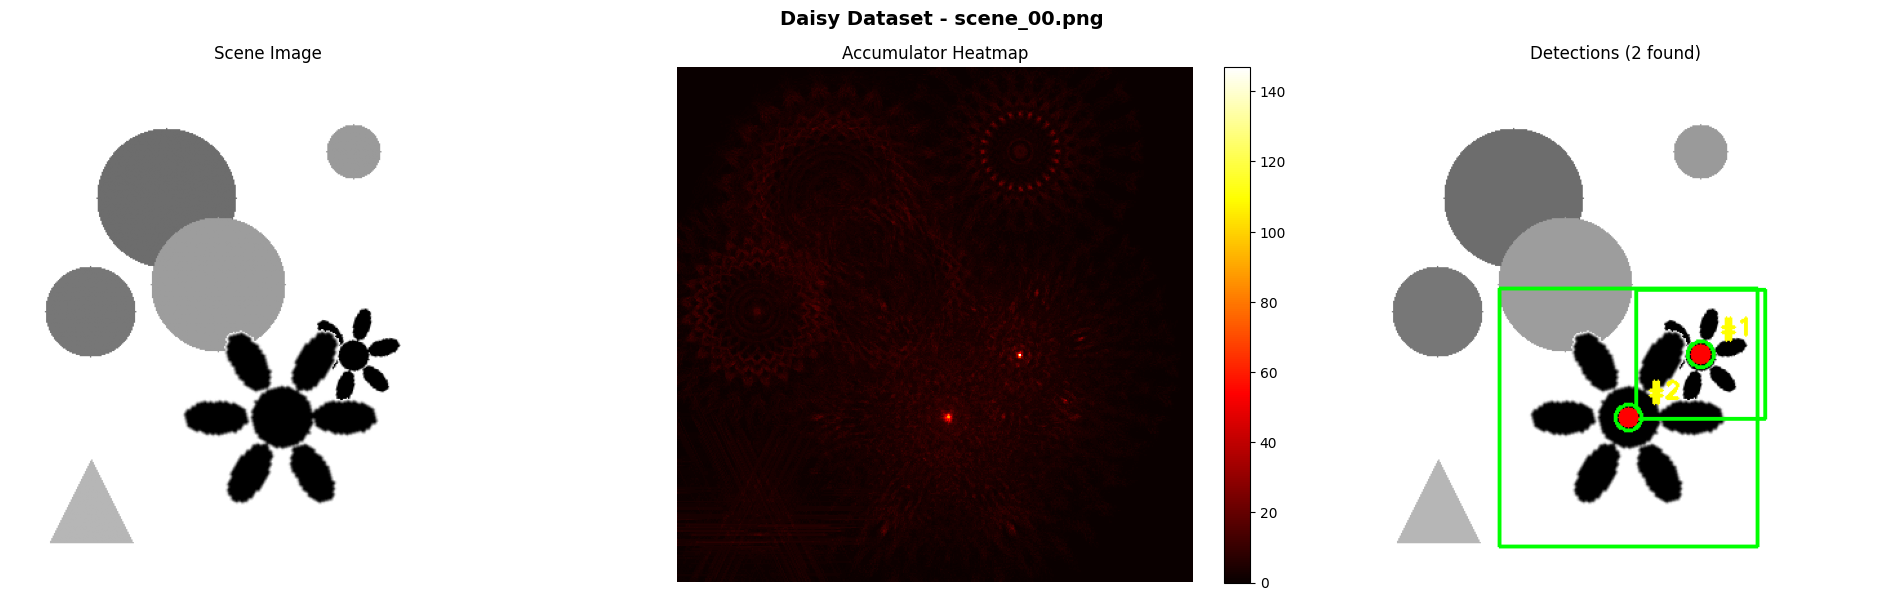


Detection Results for: Daisy Dataset - scene_00.png
Detection #1:
  Center: (266, 223)
  Scale: 1.0x
  Rotation: 285°
  Score: 147.0
Detection #2:
  Center: (210, 272)
  Scale: 2.0x
  Rotation: 300°
  Score: 90.0


********************************************************************************
Processing: scene_01.png
********************************************************************************
Searching over 4 scales and 24 rotations...
Found 3 detection(s)
Found 3 detection(s)


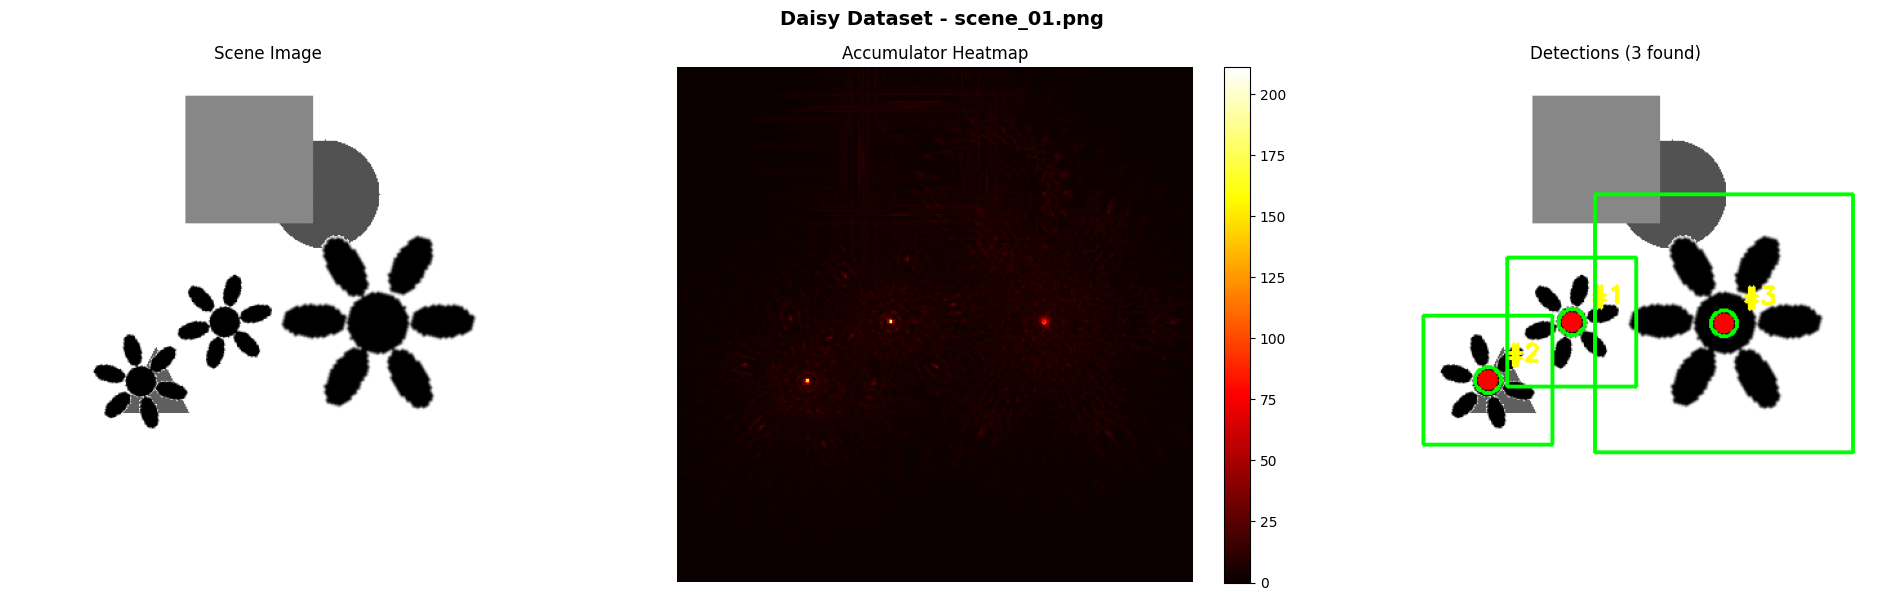


Detection Results for: Daisy Dataset - scene_01.png
Detection #1:
  Center: (166, 198)
  Scale: 1.0x
  Rotation: 345°
  Score: 211.0
Detection #2:
  Center: (101, 243)
  Scale: 1.0x
  Rotation: 255°
  Score: 166.0
Detection #3:
  Center: (284, 199)
  Scale: 2.0x
  Rotation: 60°
  Score: 103.0


********************************************************************************
Processing: scene_05.png
********************************************************************************
Searching over 4 scales and 24 rotations...
Found 1 detection(s)
Found 1 detection(s)


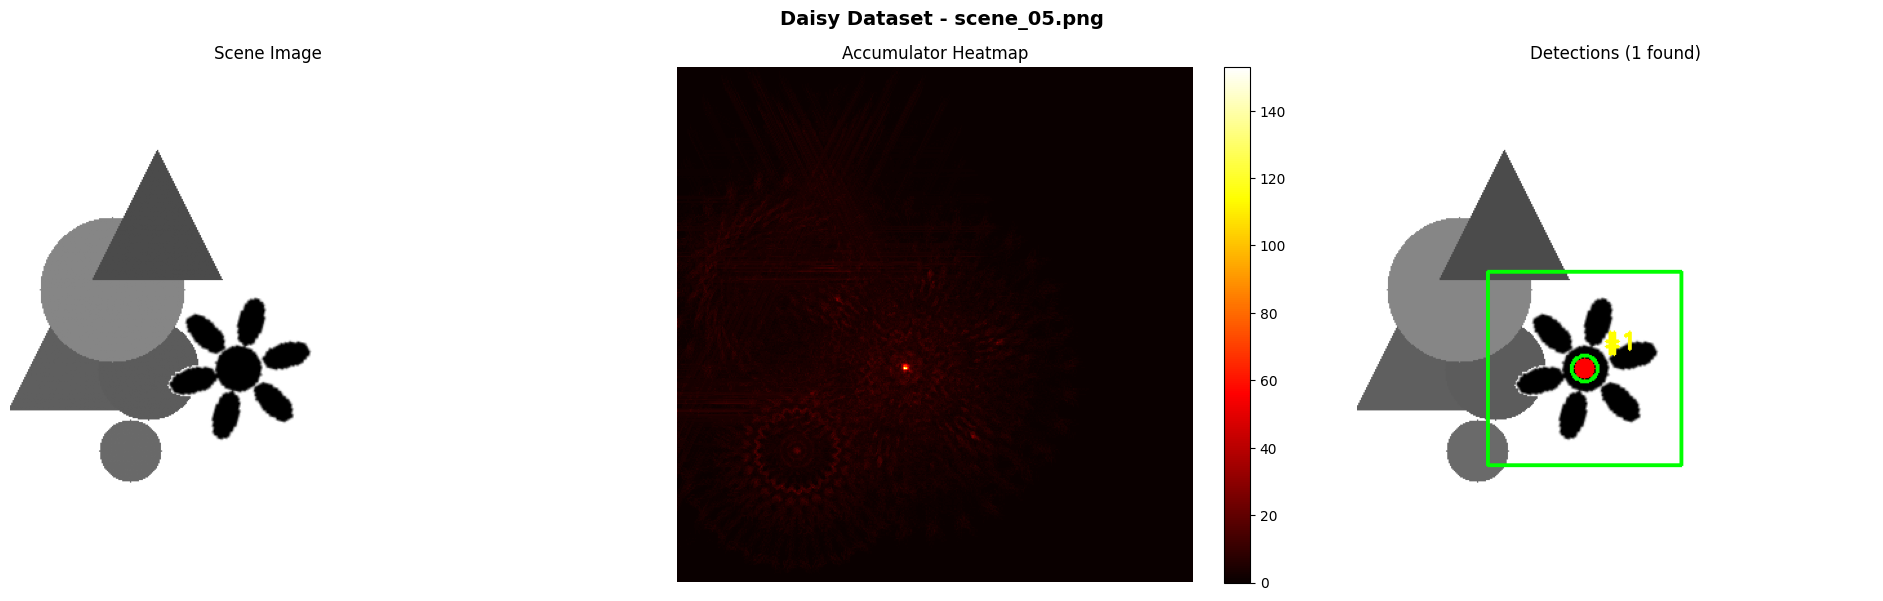


Detection Results for: Daisy Dataset - scene_05.png
Detection #1:
  Center: (176, 234)
  Scale: 1.5x
  Rotation: 105°
  Score: 153.0


********************************************************************************
Processing: scene_08.png
********************************************************************************
Searching over 4 scales and 24 rotations...
Found 1 detection(s)
Found 1 detection(s)


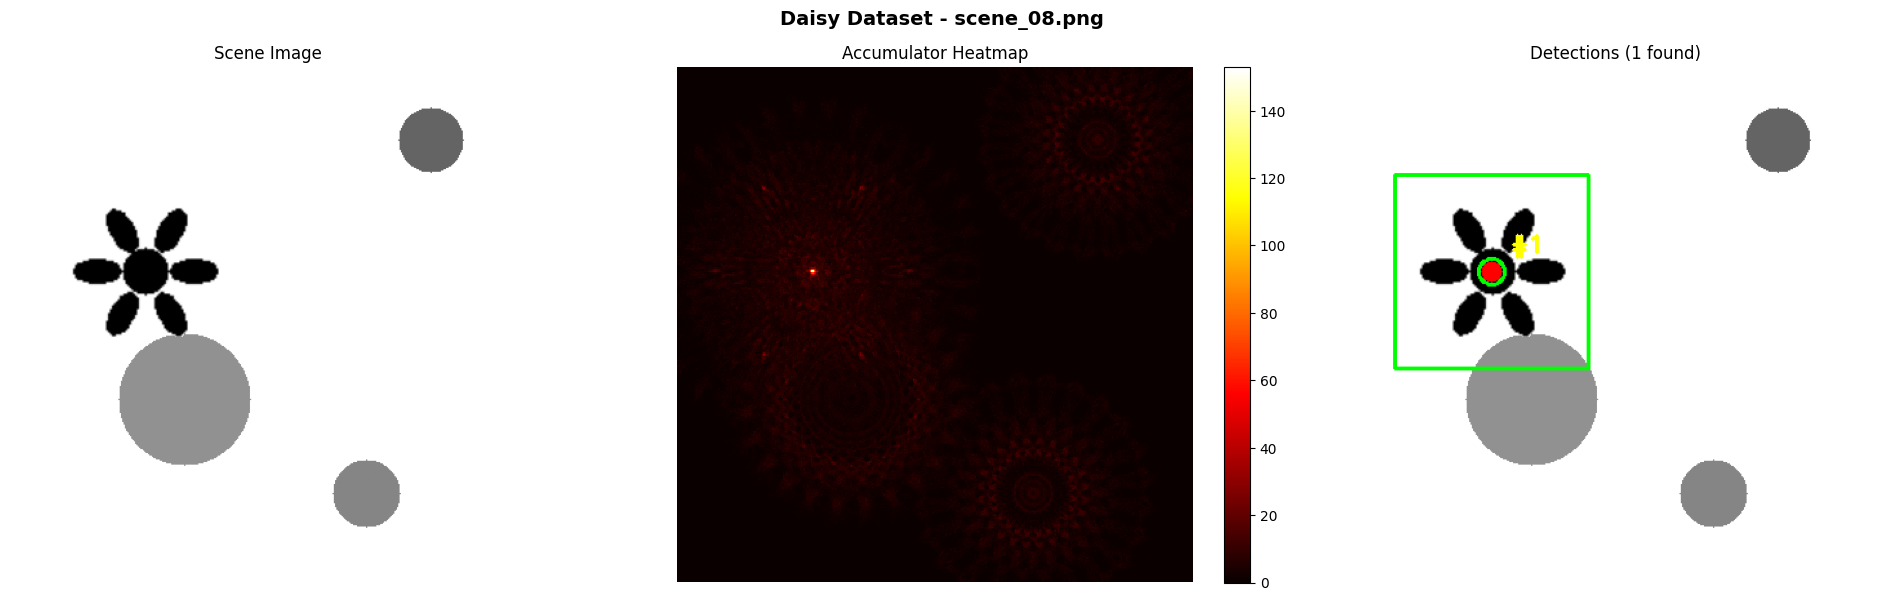


Detection Results for: Daisy Dataset - scene_08.png
Detection #1:
  Center: (104, 159)
  Scale: 1.5x
  Rotation: 180°
  Score: 153.0


********************************************************************************
Processing: scene_12.png
********************************************************************************
Searching over 4 scales and 24 rotations...
Found 1 detection(s)
Found 1 detection(s)


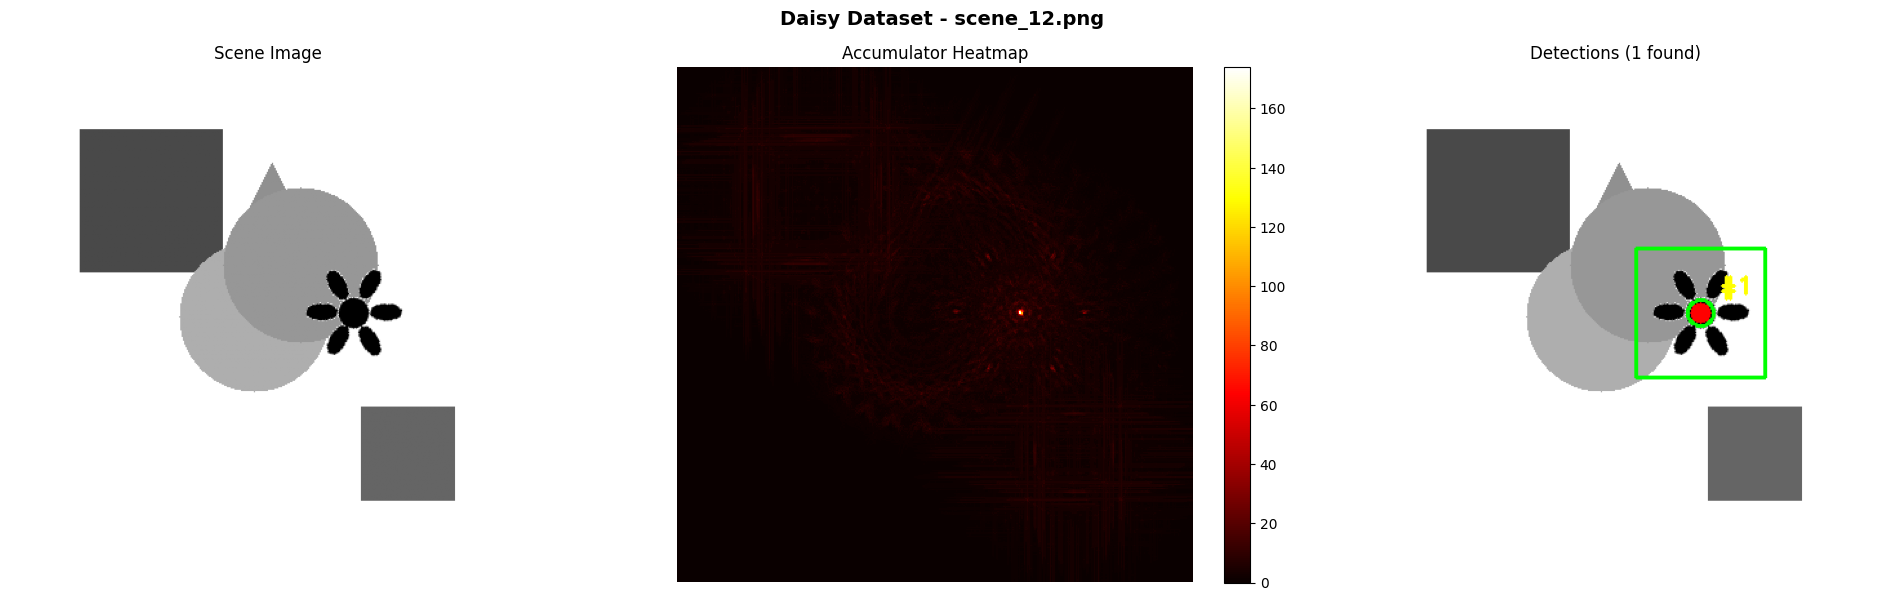


Detection Results for: Daisy Dataset - scene_12.png
Detection #1:
  Center: (266, 191)
  Scale: 1.0x
  Rotation: 60°
  Score: 174.0



In [14]:
# Test on daisy scenes
daisy_test_scenes = ['scene_00.png', 'scene_01.png', 'scene_05.png', 'scene_08.png', 'scene_12.png']

for scene_name in daisy_test_scenes:
    print(f"\n{'*'*80}")
    print(f"Processing: {scene_name}")
    print(f"{'*'*80}")
    
    # Load scene
    scene_path = os.path.join(DATASET_DIR, 'dataset_daisy', scene_name)
    scene = cv2.imread(scene_path, cv2.IMREAD_GRAYSCALE)
    
    # Detect
    detections, accumulator = daisy_ght.detect(
        scene, 
        scales=SCALES,
        rotations=ROTATIONS,
        threshold_percentile=99.99,
        min_distance=30
    )
    
    # Visualize
    save_path = os.path.join(OUTPUT_DIR, f'daisy_{scene_name}')
    visualize_detection(
        scene, daisy_template, detections, accumulator,
        save_path=save_path,
        title=f'Daisy Dataset - {scene_name}'
    )

### 4.2 Fish Dataset

In [9]:
# Load fish template and build R-table
fish_template_path = os.path.join(DATASET_DIR, 'dataset_fish', 'template.png')
fish_template = cv2.imread(fish_template_path, cv2.IMREAD_GRAYSCALE)

print("Building R-table for fish template...")
fish_ght = GeneralizedHoughTransform(fish_template, num_angle_bins=36)
fish_ght.build_r_table()

Building R-table for fish template...
R-table built with 27 angle bins
Reference point: (50, 50)



********************************************************************************
Processing: scene_00.png
********************************************************************************
Searching over 4 scales and 24 rotations...
Found 2 detection(s)
Found 2 detection(s)


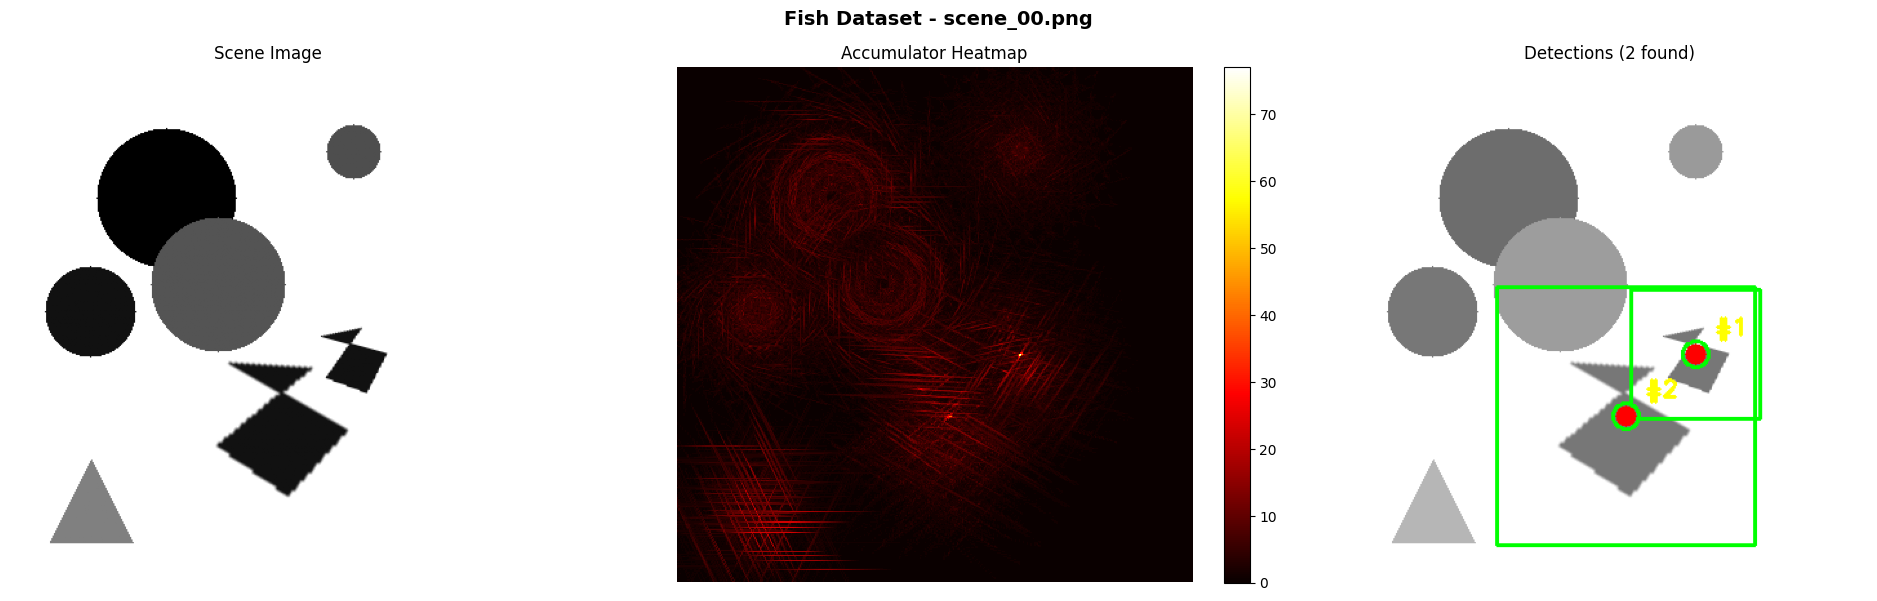


Detection Results for: Fish Dataset - scene_00.png
Detection #1:
  Center: (266, 223)
  Scale: 1.0x
  Rotation: 285°
  Score: 77.0
Detection #2:
  Center: (212, 271)
  Scale: 2.0x
  Rotation: 300°
  Score: 41.0


********************************************************************************
Processing: scene_02.png
********************************************************************************
Searching over 4 scales and 24 rotations...
Found 3 detection(s)
Found 3 detection(s)


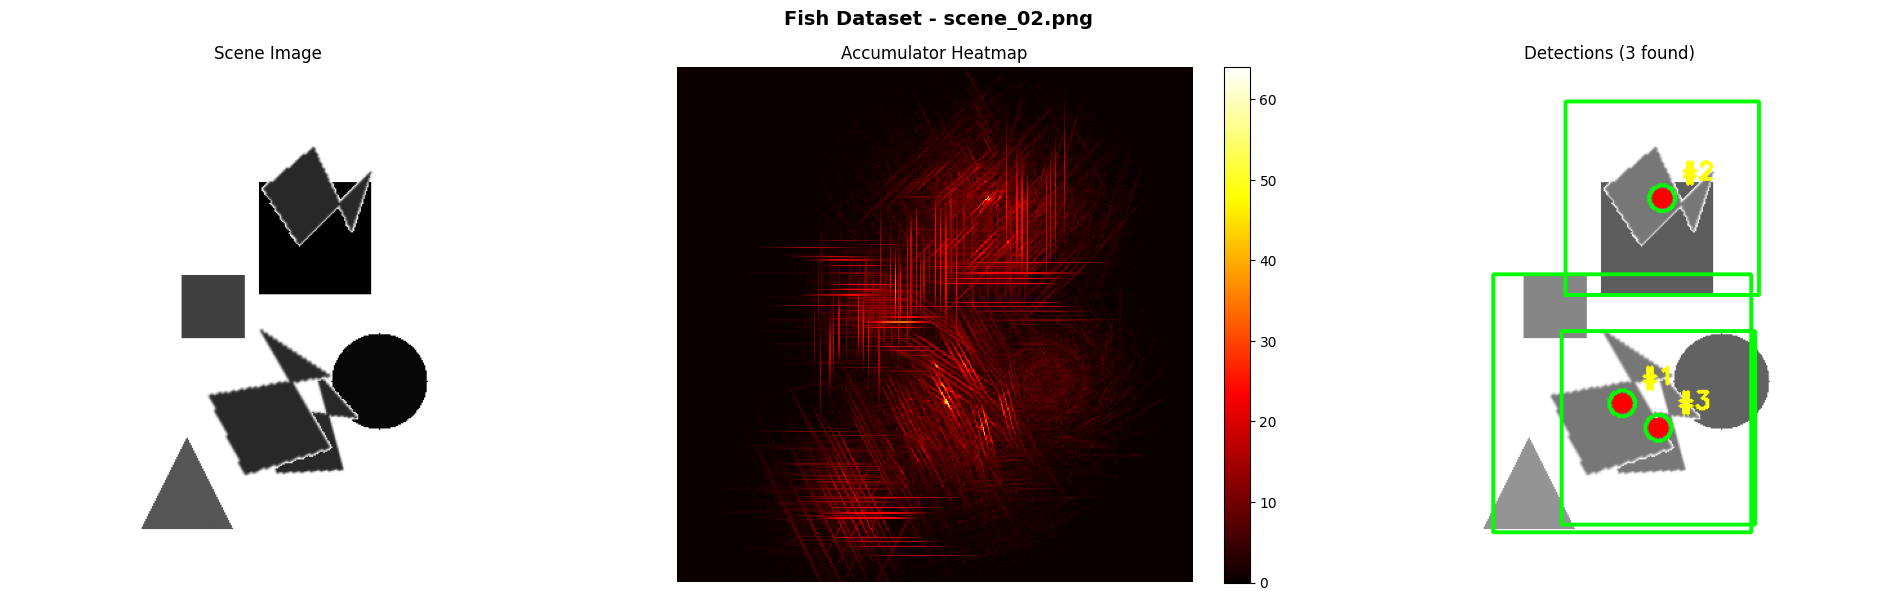


Detection Results for: Fish Dataset - scene_02.png
Detection #1:
  Center: (209, 261)
  Scale: 2.0x
  Rotation: 330°
  Score: 64.0
Detection #2:
  Center: (240, 102)
  Scale: 1.5x
  Rotation: 45°
  Score: 45.0
Detection #3:
  Center: (237, 280)
  Scale: 1.5x
  Rotation: 345°
  Score: 44.0


********************************************************************************
Processing: scene_07.png
********************************************************************************
Searching over 4 scales and 24 rotations...
Found 2 detection(s)
Found 2 detection(s)


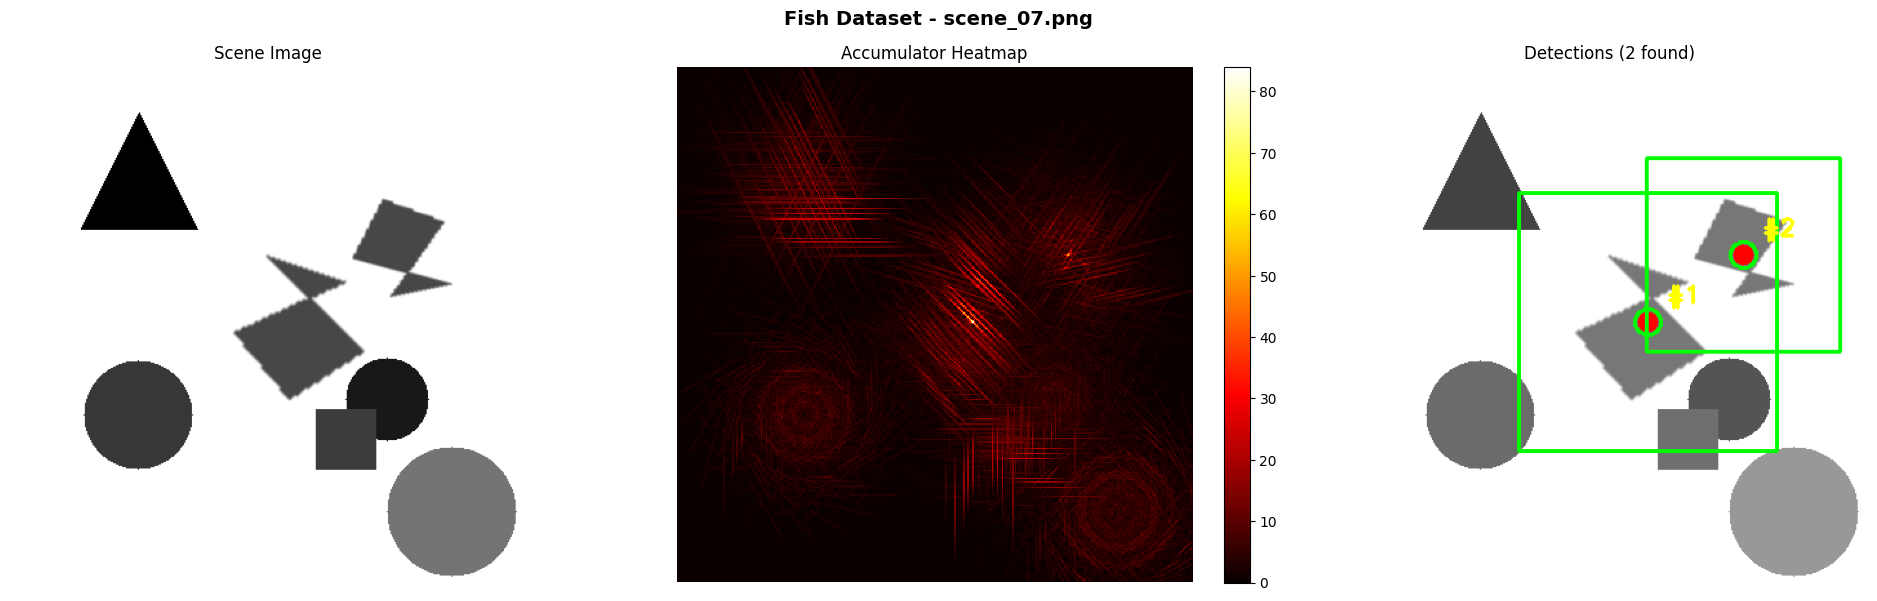


Detection Results for: Fish Dataset - scene_07.png
Detection #1:
  Center: (229, 198)
  Scale: 2.0x
  Rotation: 315°
  Score: 84.0
Detection #2:
  Center: (303, 146)
  Scale: 1.5x
  Rotation: 105°
  Score: 54.0


********************************************************************************
Processing: scene_10.png
********************************************************************************
Searching over 4 scales and 24 rotations...
Found 1 detection(s)
Found 1 detection(s)


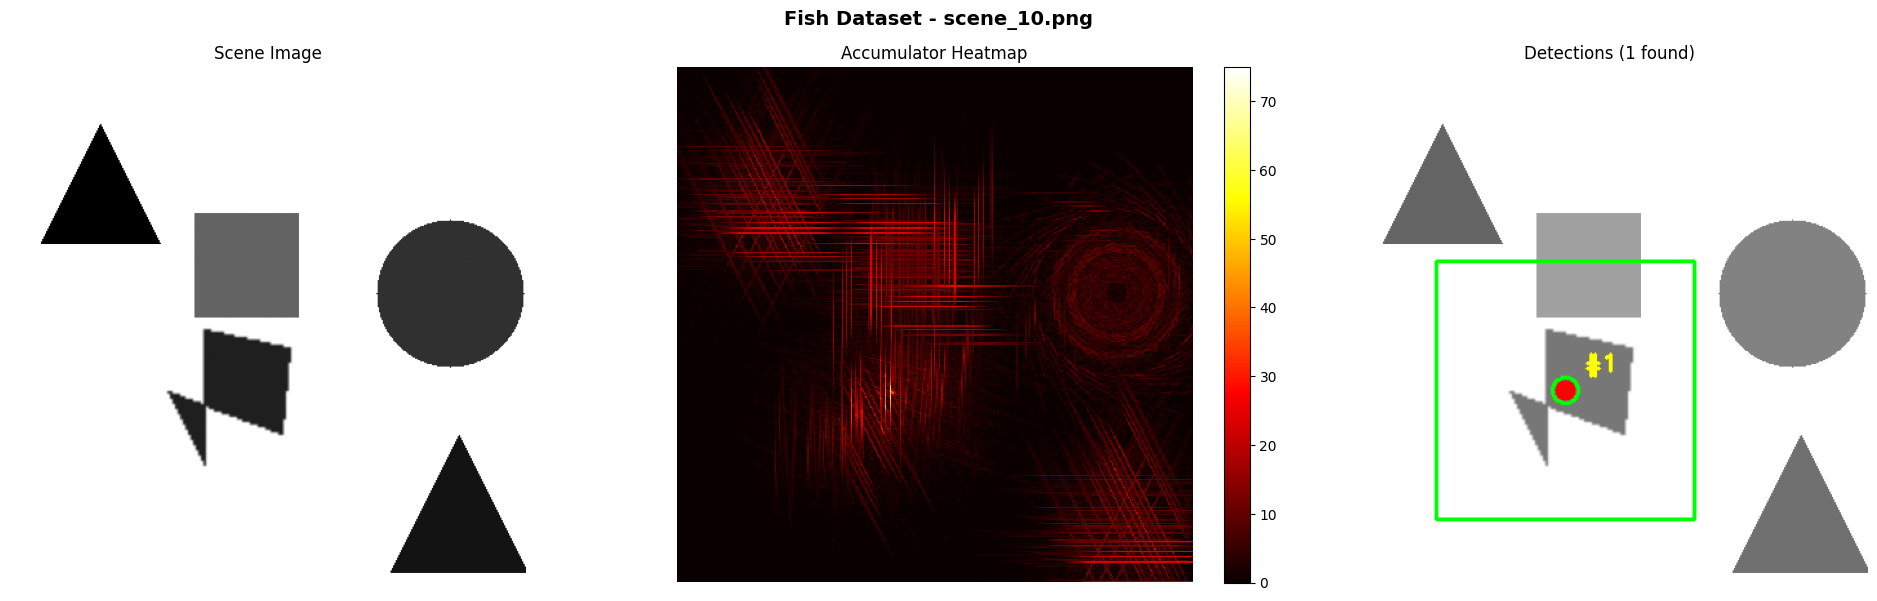


Detection Results for: Fish Dataset - scene_10.png
Detection #1:
  Center: (165, 251)
  Scale: 2.0x
  Rotation: 180°
  Score: 75.0


********************************************************************************
Processing: scene_14.png
********************************************************************************
Searching over 4 scales and 24 rotations...
Found 2 detection(s)
Found 2 detection(s)


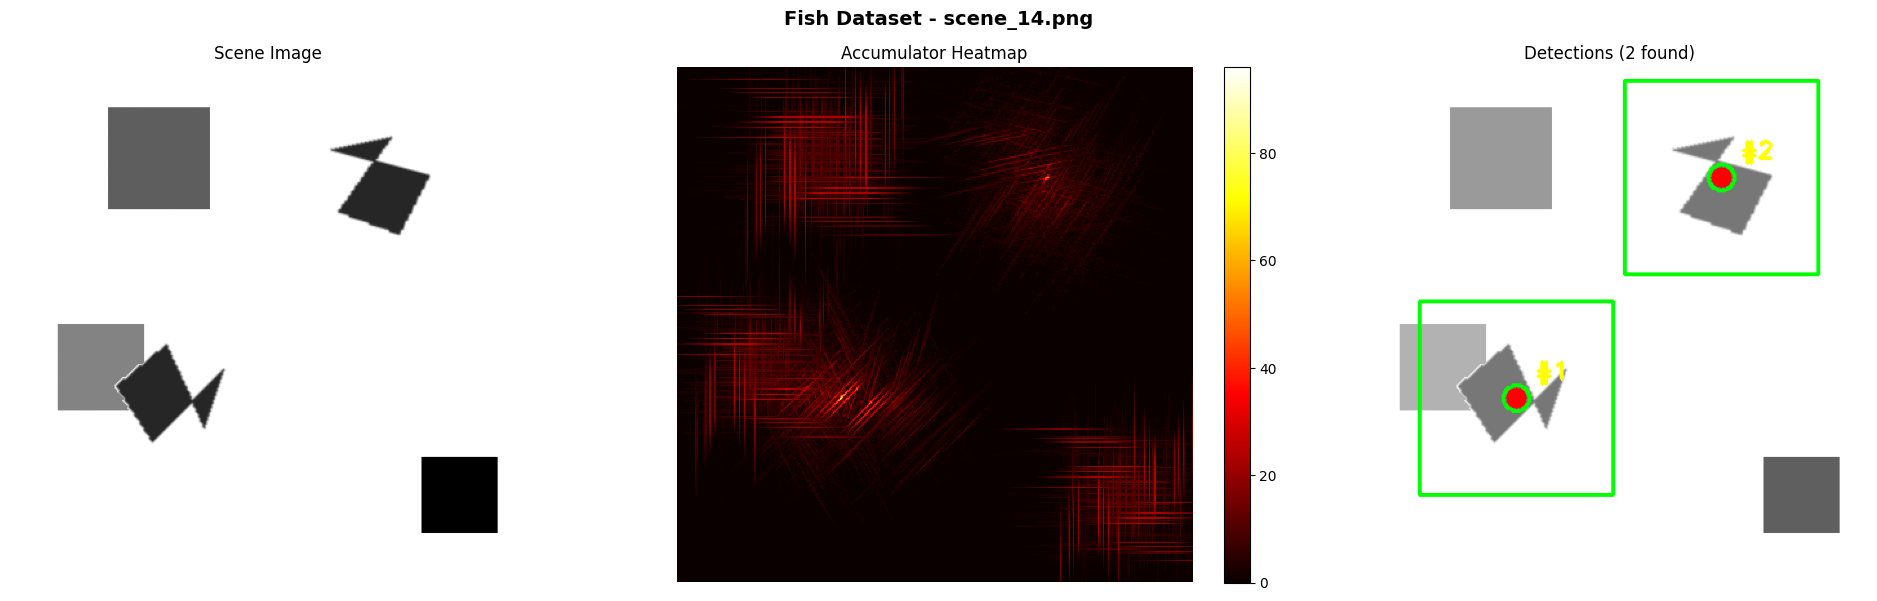


Detection Results for: Fish Dataset - scene_14.png
Detection #1:
  Center: (127, 257)
  Scale: 1.5x
  Rotation: 45°
  Score: 96.0
Detection #2:
  Center: (286, 86)
  Scale: 1.5x
  Rotation: 285°
  Score: 56.0



In [16]:
# Test on fish scenes
fish_test_scenes = ['scene_00.png', 'scene_02.png', 'scene_07.png', 'scene_10.png', 'scene_14.png']

for scene_name in fish_test_scenes:
    print(f"\n{'*'*80}")
    print(f"Processing: {scene_name}")
    print(f"{'*'*80}")
    
    # Load scene
    scene_path = os.path.join(DATASET_DIR, 'dataset_fish', scene_name)
    scene = cv2.imread(scene_path, cv2.IMREAD_GRAYSCALE)
    
    # Detect
    detections, accumulator = fish_ght.detect(
        scene, 
        scales=SCALES,
        rotations=ROTATIONS,
        threshold_percentile=99.99,
        min_distance=30
    )
    
    # Visualize
    save_path = os.path.join(OUTPUT_DIR, f'fish_{scene_name}')
    visualize_detection(
        scene, fish_template, detections, accumulator,
        save_path=save_path,
        title=f'Fish Dataset - {scene_name}'
    )

## 5. Evaluation and Comparison

In this section, I compared the performance of GHT on the two datasets.

### Observations:

#### **Daisy Dataset:**
- The daisy flower has a **circular, radially symmetric** structure with distinct petal edges
- This creates **strong, consistent edge patterns** that map well to the R-table
- The radial symmetry means similar gradient directions occur at multiple locations, creating **robust voting patterns**
- Detection accuracy is generally **high** for various scales and rotations
- Peaks in the accumulator are typically **sharp and well-defined**

#### **Fish Dataset:**
- The fish has an **asymmetric, elongated shape** with varied edge orientations
- Edge gradients are more **diverse and spread out** across the shape
- This can lead to **weaker voting** in the accumulator, especially for rotated instances
- Detection may be **more sensitive** to rotation angles
- Accumulator peaks might be **less pronounced** compared to daisy

#### **Which template is easier to detect?**
The **daisy template** is typically easier to detect because:
1. **Radial symmetry**: Similar edge patterns repeat around the center, reinforcing votes
2. **Compact shape**: The circular structure concentrates votes in a smaller region
3. **Distinct edges**: Clear petal boundaries create strong gradient information
4. **Rotation invariance**: Circular shapes are naturally more rotation-invariant

The fish template is **more challenging** because:
1. **Asymmetry**: Different orientations produce very different edge patterns
2. **Elongated shape**: Votes are distributed over a larger area
3. **Directional features**: Performance depends more heavily on correct rotation estimation

#### **Why does this happen?**
GHT relies on the consistency of gradient directions relative to a reference point. Symmetric objects like the daisy produce **repeating gradient patterns** that create strong, focused peaks in the accumulator. Asymmetric objects like the fish have **unique gradients at each location**, which requires more precise scale and rotation matching to accumulate sufficient votes.

## 6. Failure Cases and Challenges

Let's examine some challenging scenarios where GHT may struggle.

Testing on challenging scenarios...


Challenge: Multiple daisies at different scales
Dataset: dataset_daisy, Scene: scene_15.png
Searching over 4 scales and 24 rotations...
Found 4 detection(s)


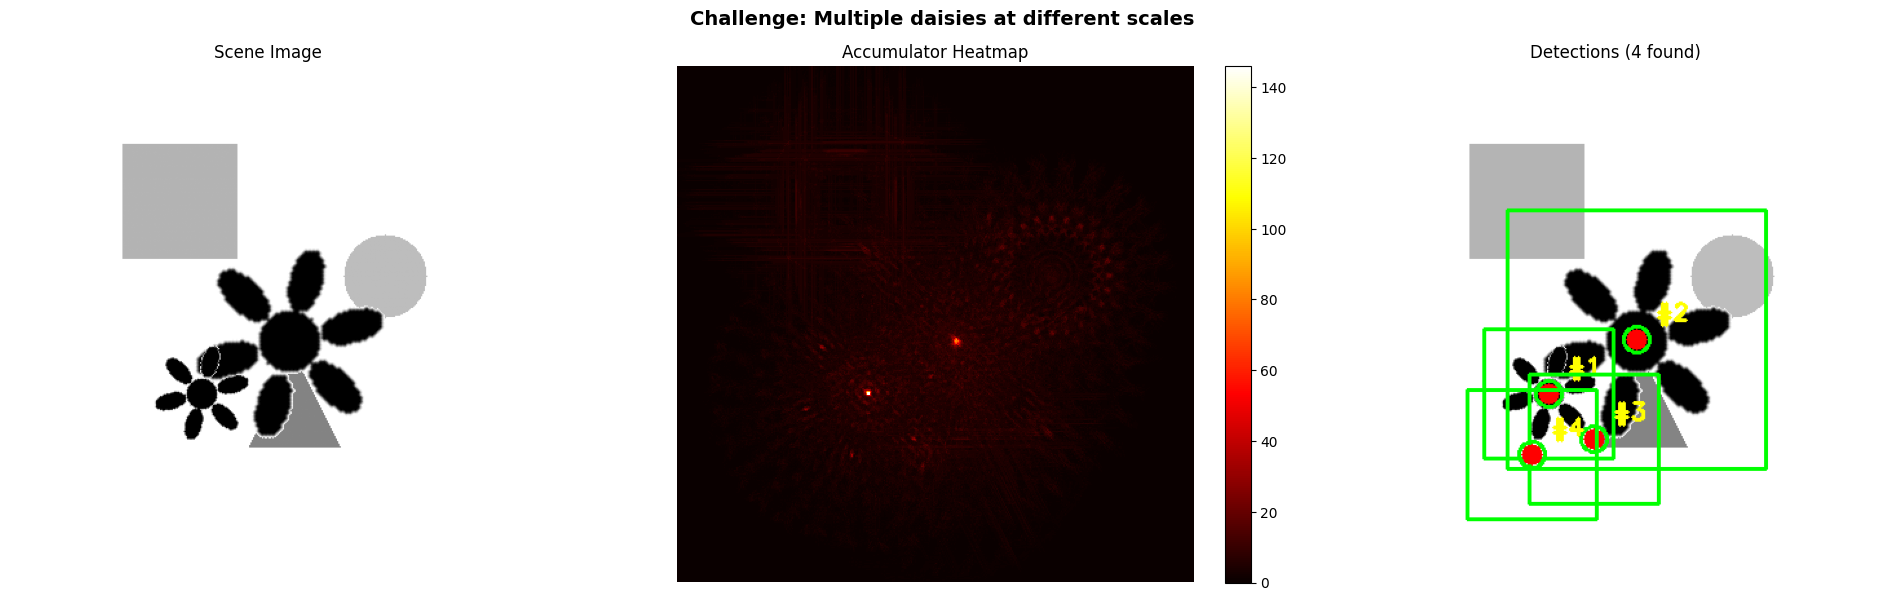


Detection Results for: Challenge: Multiple daisies at different scales
Detection #1:
  Center: (148, 254)
  Scale: 1.0x
  Rotation: 45°
  Score: 146.0
Detection #2:
  Center: (216, 212)
  Scale: 2.0x
  Rotation: 225°
  Score: 86.0
Detection #3:
  Center: (183, 289)
  Scale: 1.0x
  Rotation: 45°
  Score: 33.0
Detection #4:
  Center: (135, 301)
  Scale: 1.0x
  Rotation: 45°
  Score: 32.0


Challenge: Fish with collapsing shapes
Dataset: dataset_fish, Scene: scene_06.png
Searching over 4 scales and 24 rotations...
Found 4 detection(s)


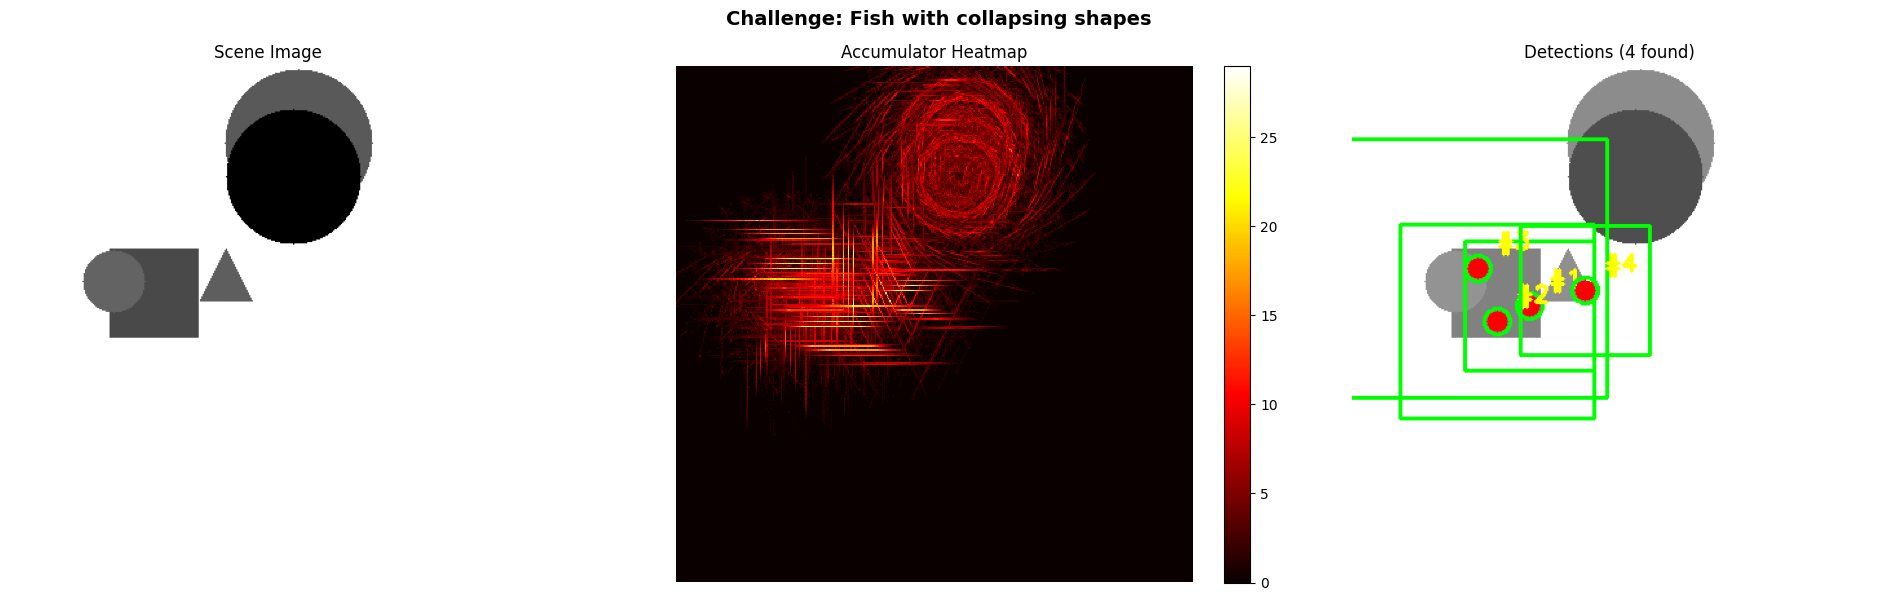


Detection Results for: Challenge: Fish with collapsing shapes
Detection #1:
  Center: (137, 186)
  Scale: 1.0x
  Rotation: 0°
  Score: 29.0
Detection #2:
  Center: (112, 198)
  Scale: 1.5x
  Rotation: 90°
  Score: 26.0
Detection #3:
  Center: (97, 157)
  Scale: 2.0x
  Rotation: 270°
  Score: 25.0
Detection #4:
  Center: (180, 174)
  Scale: 1.0x
  Rotation: 90°
  Score: 24.0



In [44]:
# Test on potentially challenging scenes
print("Testing on challenging scenarios...\n")

# Example 1: Multiple objects at different scales
challenging_scenes = [
    ('dataset_daisy', 'scene_15.png', "Multiple daisies at different scales"),
    ('dataset_fish', 'scene_06.png', "Fish with collapsing shapes"),
]

for dataset, scene_name, description in challenging_scenes:
    print(f"\n{'='*80}")
    print(f"Challenge: {description}")
    print(f"Dataset: {dataset}, Scene: {scene_name}")
    print(f"{'='*80}")
    
    # Load scene
    scene_path = os.path.join(DATASET_DIR, dataset, scene_name)
    scene = cv2.imread(scene_path, cv2.IMREAD_GRAYSCALE)
    
    # Select appropriate GHT and template
    if 'daisy' in dataset:
        ght = daisy_ght
        template = daisy_template
    else:
        ght = fish_ght
        template = fish_template
    
    # Detect
    detections, accumulator = ght.detect(
        scene,
        scales=SCALES,
        rotations=ROTATIONS,
        threshold_percentile=99.95,
        min_distance=25
    )
    
    # Visualize
    save_path = os.path.join(OUTPUT_DIR, f'challenge_{dataset}_{scene_name}')
    visualize_detection(
        scene, template, detections, accumulator,
        save_path=save_path,
        title=f'Challenge: {description}'
    )

### Common Failure Modes:

1. **Occlusion**: When the template object is partially occluded, some edge points are missing, leading to incomplete voting patterns and weaker accumulator peaks.

2. **Cluttered Backgrounds**: Complex backgrounds with many edges create noise in the accumulator. Background edges vote for random locations, making it harder to distinguish true object centers from false positives.

3. **Scale/Rotation Mismatch**: If the actual object scale or rotation doesn't match our discrete search values (e.g., object is at 1.7× scale but we only search 1.5× and 2.0×), the votes will be split and peaks may be suppressed.

4. **Multiple Objects**: When multiple instances of the object are close together, their voting regions may overlap, making it difficult to separate individual detections even with non-maximum suppression.

5. **Low Contrast or Poor Edge Detection**: If the template edges are weak or noisy in the scene (due to lighting, blur, or low contrast), edge detection may fail to capture the shape properly, resulting in missed detections.

6. **Template Deformation**: If the object in the scene is deformed, stretched, or has a different perspective than the template, GHT (which assumes rigid transformations) will fail to detect it accurately.

## 7. Summary and Conclusions

### What I Learned:

Through this assignment, I gained practical experience with the **Generalized Hough Transform** algorithm and its application to object detection. Key takeaways include:

1. **R-table Construction**: Understanding how to map gradient directions to displacement vectors is fundamental to GHT. The R-table efficiently encodes the shape of the template.

2. **Voting Mechanism**: The voting process in parameter space (position, scale, rotation) is an elegant way to handle object detection under transformations. Each edge point contributes votes based on local gradient information.

3. **Parameter Space Search**: Searching over discrete scales and rotations is computationally expensive but necessary for robust detection. The choice of search granularity affects both accuracy and runtime.

4. **Shape Characteristics Matter**: Symmetric, compact shapes with strong edges (like the daisy) produce clearer peaks and are easier to detect than asymmetric shapes (like the fish).

5. **Practical Challenges**: Real-world detection faces challenges like background clutter, occlusion, and parameter sensitivity that require careful tuning of thresholds and search parameters.

### Potential Improvements:

1. **Hierarchical Search**: Use a coarse-to-fine strategy to first search with large steps, then refine around promising candidates.

2. **Adaptive Thresholding**: Implement dynamic threshold selection based on accumulator statistics rather than fixed percentiles.

3. **Edge Weighting**: Weight votes by edge strength or gradient magnitude to give more importance to strong, reliable edges.

4. **Multi-scale Template**: Build multiple R-tables at different scales to improve scale detection accuracy.

5. **Probabilistic Framework**: Use a probabilistic voting scheme to handle uncertainty and partial matches more robustly.

6. **GPU Acceleration**: Parallelize the voting process across scales and rotations to significantly speed up detection.

### Conclusion:

The Generalized Hough Transform is a powerful geometric approach to object detection that is particularly effective for objects with distinctive shape boundaries. While it has limitations (computational cost, sensitivity to parameters, assumption of rigid transformations), it provides valuable insights into shape-based recognition and serves as a foundation for understanding more advanced detection methods.